In [1]:
#Check this out babe
# Install any dependencies
!pip install imantics --quiet

  Preparing metadata (setup.py) ... done


In [2]:
# -----------------------------------
# 1. Mount Google Drive
# -----------------------------------
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Change to your folder
BASE_DIR =  '/content/drive/MyDrive/retina project/DRIVE_unzipped/DRIVE'  # <-- adjust to your path
TRAIN_IMG_DIR   = f"{BASE_DIR}/training/images"
TRAIN_MASK_DIR  = f"{BASE_DIR}/training/1st_manual"
TEST_IMG_DIR    = f"{BASE_DIR}/test/images"
TEST_MASK_DIR   = f"{BASE_DIR}/test/1st_manual"

In [4]:
# -----------------------------------
# 2. Imports & Params
# -----------------------------------
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

# image size
IMG_SIZE = 512
BATCH_SIZE = 4
EPOCHS = 250

In [5]:
# helper to load and preprocess
import cv2
import numpy as np
import os

# Create the CLAHE object (you only need to do this once)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

def load_images(folder, file_pattern, is_mask=False):
    """
    Loads images from a folder, filtering by a file_pattern.
    - Applies CLAHE contrast enhancement to input images.
    - Correctly normalizes both images and masks.
    """
    imgs = []
    for fname in sorted(os.listdir(folder)):
        # 1. Filter files based on the file_pattern and extension
        if file_pattern not in fname:
            continue
        # Support for different file types in DRIVE dataset
        if not (fname.endswith('.png') or fname.endswith('.tif') or fname.endswith('.jpg')):
            continue

        path = os.path.join(folder, fname)
        img = cv2.imread(path, cv2.IMREAD_COLOR if not is_mask else cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Warning: Could not read image at {path}")
            continue

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        if not is_mask:
            # --- This is the new CLAHE logic for input images ---
            # a. Extract the green channel
            green_channel = img[:,:,1]
            # b. Apply CLAHE
            enhanced_green_channel = clahe.apply(green_channel)
            # c. Normalize and add a channel dimension for the model
            img = enhanced_green_channel.astype('float32') / 255.0
            img = np.expand_dims(img, axis=-1)
        else:
            # --- This is the corrected normalization for masks ---
            img = img.astype('float32') / 255.0
            img = np.expand_dims(img, axis=-1)

        imgs.append(img)
    return np.array(imgs)

# Load TRAIN (21–40) and TEST (01–20)
X_train = load_images(TRAIN_IMG_DIR, file_pattern='_training.png', is_mask=False)
y_train = load_images(TRAIN_MASK_DIR,  file_pattern='_manual1.png', is_mask=True)
X_test  = load_images(TEST_IMG_DIR,  file_pattern='_test.png',   is_mask=False)
y_test  = load_images(TEST_MASK_DIR, file_pattern='_manual1.png', is_mask=True)

print("Train:", X_train.shape, y_train.shape)
print("Test: ",  X_test.shape,  y_test.shape)

# split train-> train/val
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

Train: (20, 512, 512, 1) (20, 512, 512, 1)
Test:  (20, 512, 512, 1) (20, 512, 512, 1)


In [6]:
# -----------------------------------
# 3. Build U-Net++ (Nested U-Net)
# -----------------------------------
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    return x

def nested_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3), deep_supervision=False):
    inputs = layers.Input(input_shape)

    # Encoder
    x0_0 = conv_block(inputs,    64)
    p0   = layers.MaxPool2D()(x0_0)

    x1_0 = conv_block(p0,        128)
    p1   = layers.MaxPool2D()(x1_0)

    x2_0 = conv_block(p1,        256)
    p2   = layers.MaxPool2D()(x2_0)

    x3_0 = conv_block(p2,        512)
    p3   = layers.MaxPool2D()(x3_0)

    x4_0 = conv_block(p3,        1024)

    # Decoder with nested skips
    x3_1 = conv_block(
        layers.Concatenate()([
            layers.UpSampling2D()(x4_0),
            x3_0
        ]), 512)

    x2_2 = conv_block(
        layers.Concatenate()([
            layers.UpSampling2D()(x3_1),
            x2_0
        ]), 256)

    x1_3 = conv_block(
        layers.Concatenate()([
            layers.UpSampling2D()(x2_2),
            x1_0
        ]), 128)

    x0_4 = conv_block(
        layers.Concatenate()([
            layers.UpSampling2D()(x1_3),
            x0_0
        ]), 64)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x0_4)
    model   = models.Model(inputs, outputs)
    return model

model = nested_unet(input_shape=(IMG_SIZE, IMG_SIZE, 1))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │  1,180,160 │ max_pooling2d_2[

 Total params: 31,401,345 (119.79 MB)

 Trainable params: 31,389,569 (119.74 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [7]:
# -----------------------------------
# 4. Train & Save Best U-Net++
# -----------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

# define checkpoint to save only the best model by val_loss
checkpoint_cb = ModelCheckpoint(
    filepath="/content/drive/MyDrive/retina project/best_model_unet(++).h5",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb],
    verbose=2
)


Epoch 1/250

Epoch 1: val_loss improved from inf to 0.81828, saving model to /content/drive/MyDrive/retina project/best_model_unet(++).h5


4/4 - 48s - 12s/step - accuracy: 0.5045 - loss: 0.8718 - val_accuracy: 0.8746 - val_loss: 0.8183
Epoch 2/250

Epoch 2: val_loss did not improve from 0.81828
4/4 - 1s - 133ms/step - accuracy: 0.7183 - loss: 0.5938 - val_accuracy: 0.8746 - val_loss: 7.9825
Epoch 3/250

Epoch 3: val_loss did not improve from 0.81828
4/4 - 0s - 124ms/step - accuracy: 0.8478 - loss: 0.5215 - val_accuracy: 0.8708 - val_loss: 25.4075
Epoch 4/250

Epoch 4: val_loss did not improve from 0.81828
4/4 - 1s - 126ms/step - accuracy: 0.8794 - loss: 0.4725 - val_accuracy: 0.8707 - val_loss: 52.8352
Epoch 5/250

Epoch 5: val_loss did not improve from 0.81828
4/4 - 0s - 124ms/step - accuracy: 0.8964 - loss: 0.4287 - val_accuracy: 0.8706 - val_loss: 29.8406
Epoch 6/250

Epoch 6: val_loss did not improve from 0.81828
4/4 - 1s - 125ms/step - accuracy: 0.9048 - loss: 0.3941 - val_accuracy: 0.8089 - val_loss: 1.1845
Epoch 7/250

Epoch 7: val_loss did not improve from 0.81828
4/4 - 0s - 124ms/step - accuracy: 0.9089 - loss: 0

4/4 - 2s - 460ms/step - accuracy: 0.9229 - loss: 0.1636 - val_accuracy: 0.8746 - val_loss: 0.2874
Epoch 29/250

Epoch 29: val_loss did not improve from 0.28743
4/4 - 0s - 124ms/step - accuracy: 0.9206 - loss: 0.1750 - val_accuracy: 0.4046 - val_loss: 0.6304
Epoch 30/250

Epoch 30: val_loss did not improve from 0.28743
4/4 - 0s - 123ms/step - accuracy: 0.9197 - loss: 0.1757 - val_accuracy: 0.8746 - val_loss: 0.2915
Epoch 31/250

Epoch 31: val_loss did not improve from 0.28743
4/4 - 0s - 125ms/step - accuracy: 0.9195 - loss: 0.1725 - val_accuracy: 0.8746 - val_loss: 0.3260
Epoch 32/250

Epoch 32: val_loss did not improve from 0.28743
4/4 - 0s - 123ms/step - accuracy: 0.9212 - loss: 0.1617 - val_accuracy: 0.8746 - val_loss: 0.3297
Epoch 33/250

Epoch 33: val_loss did not improve from 0.28743
4/4 - 0s - 123ms/step - accuracy: 0.9202 - loss: 0.1583 - val_accuracy: 0.8746 - val_loss: 0.3360
Epoch 34/250

Epoch 34: val_loss did not improve from 0.28743
4/4 - 0s - 123ms/step - accuracy: 0.9216

4/4 - 2s - 385ms/step - accuracy: 0.9272 - loss: 0.0808 - val_accuracy: 0.8803 - val_loss: 0.2503
Epoch 112/250

Epoch 112: val_loss did not improve from 0.25028
4/4 - 0s - 124ms/step - accuracy: 0.9276 - loss: 0.0798 - val_accuracy: 0.8800 - val_loss: 0.2801
Epoch 113/250

Epoch 113: val_loss did not improve from 0.25028
4/4 - 0s - 124ms/step - accuracy: 0.9276 - loss: 0.0785 - val_accuracy: 0.8786 - val_loss: 0.2601
Epoch 114/250

Epoch 114: val_loss did not improve from 0.25028
4/4 - 0s - 124ms/step - accuracy: 0.9278 - loss: 0.0776 - val_accuracy: 0.8813 - val_loss: 0.2696
Epoch 115/250

Epoch 115: val_loss did not improve from 0.25028
4/4 - 0s - 123ms/step - accuracy: 0.9277 - loss: 0.0775 - val_accuracy: 0.8814 - val_loss: 0.2965
Epoch 116/250

Epoch 116: val_loss did not improve from 0.25028
4/4 - 0s - 123ms/step - accuracy: 0.9280 - loss: 0.0774 - val_accuracy: 0.8788 - val_loss: 0.3020
Epoch 117/250

Epoch 117: val_loss did not improve from 0.25028
4/4 - 0s - 124ms/step - accu

4/4 - 2s - 413ms/step - accuracy: 0.9287 - loss: 0.0699 - val_accuracy: 0.8922 - val_loss: 0.2401
Epoch 131/250

Epoch 131: val_loss improved from 0.24011 to 0.23100, saving model to /content/drive/MyDrive/retina project/best_model_unet(++).h5


4/4 - 2s - 396ms/step - accuracy: 0.9289 - loss: 0.0707 - val_accuracy: 0.8922 - val_loss: 0.2310
Epoch 132/250

Epoch 132: val_loss improved from 0.23100 to 0.20552, saving model to /content/drive/MyDrive/retina project/best_model_unet(++).h5


4/4 - 2s - 410ms/step - accuracy: 0.9292 - loss: 0.0689 - val_accuracy: 0.8994 - val_loss: 0.2055
Epoch 133/250

Epoch 133: val_loss did not improve from 0.20552
4/4 - 0s - 125ms/step - accuracy: 0.9290 - loss: 0.0692 - val_accuracy: 0.8972 - val_loss: 0.2323
Epoch 134/250

Epoch 134: val_loss did not improve from 0.20552
4/4 - 0s - 125ms/step - accuracy: 0.9292 - loss: 0.0684 - val_accuracy: 0.8939 - val_loss: 0.2340
Epoch 135/250

Epoch 135: val_loss did not improve from 0.20552
4/4 - 0s - 124ms/step - accuracy: 0.9291 - loss: 0.0691 - val_accuracy: 0.8936 - val_loss: 0.2368
Epoch 136/250

Epoch 136: val_loss did not improve from 0.20552
4/4 - 0s - 124ms/step - accuracy: 0.9292 - loss: 0.0679 - val_accuracy: 0.9000 - val_loss: 0.2167
Epoch 137/250

Epoch 137: val_loss did not improve from 0.20552
4/4 - 0s - 125ms/step - accuracy: 0.9294 - loss: 0.0666 - val_accuracy: 0.8950 - val_loss: 0.2308
Epoch 138/250

Epoch 138: val_loss improved from 0.20552 to 0.19780, saving model to /conten

4/4 - 2s - 406ms/step - accuracy: 0.9296 - loss: 0.0666 - val_accuracy: 0.9001 - val_loss: 0.1978
Epoch 139/250

Epoch 139: val_loss improved from 0.19780 to 0.18659, saving model to /content/drive/MyDrive/retina project/best_model_unet(++).h5


4/4 - 2s - 407ms/step - accuracy: 0.9298 - loss: 0.0652 - val_accuracy: 0.9058 - val_loss: 0.1866
Epoch 140/250

Epoch 140: val_loss did not improve from 0.18659
4/4 - 0s - 125ms/step - accuracy: 0.9298 - loss: 0.0647 - val_accuracy: 0.9026 - val_loss: 0.1910
Epoch 141/250

Epoch 141: val_loss did not improve from 0.18659
4/4 - 0s - 123ms/step - accuracy: 0.9298 - loss: 0.0646 - val_accuracy: 0.9043 - val_loss: 0.1917
Epoch 142/250

Epoch 142: val_loss did not improve from 0.18659
4/4 - 0s - 124ms/step - accuracy: 0.9299 - loss: 0.0645 - val_accuracy: 0.9012 - val_loss: 0.2046
Epoch 143/250

Epoch 143: val_loss improved from 0.18659 to 0.17125, saving model to /content/drive/MyDrive/retina project/best_model_unet(++).h5


4/4 - 2s - 403ms/step - accuracy: 0.9301 - loss: 0.0636 - val_accuracy: 0.9094 - val_loss: 0.1713
Epoch 144/250

Epoch 144: val_loss did not improve from 0.17125
4/4 - 1s - 125ms/step - accuracy: 0.9302 - loss: 0.0626 - val_accuracy: 0.9004 - val_loss: 0.2059
Epoch 145/250

Epoch 145: val_loss improved from 0.17125 to 0.16409, saving model to /content/drive/MyDrive/retina project/best_model_unet(++).h5


4/4 - 2s - 407ms/step - accuracy: 0.9303 - loss: 0.0622 - val_accuracy: 0.9098 - val_loss: 0.1641
Epoch 146/250

Epoch 146: val_loss improved from 0.16409 to 0.16179, saving model to /content/drive/MyDrive/retina project/best_model_unet(++).h5


4/4 - 2s - 407ms/step - accuracy: 0.9298 - loss: 0.0638 - val_accuracy: 0.9085 - val_loss: 0.1618
Epoch 147/250

Epoch 147: val_loss improved from 0.16179 to 0.15673, saving model to /content/drive/MyDrive/retina project/best_model_unet(++).h5


4/4 - 2s - 413ms/step - accuracy: 0.9303 - loss: 0.0631 - val_accuracy: 0.9098 - val_loss: 0.1567
Epoch 148/250

Epoch 148: val_loss did not improve from 0.15673
4/4 - 1s - 126ms/step - accuracy: 0.9295 - loss: 0.0644 - val_accuracy: 0.9062 - val_loss: 0.1722
Epoch 149/250

Epoch 149: val_loss did not improve from 0.15673
4/4 - 0s - 124ms/step - accuracy: 0.9302 - loss: 0.0624 - val_accuracy: 0.9097 - val_loss: 0.1664
Epoch 150/250

Epoch 150: val_loss did not improve from 0.15673
4/4 - 0s - 124ms/step - accuracy: 0.9303 - loss: 0.0619 - val_accuracy: 0.9111 - val_loss: 0.1609
Epoch 151/250

Epoch 151: val_loss improved from 0.15673 to 0.15010, saving model to /content/drive/MyDrive/retina project/best_model_unet(++).h5


4/4 - 2s - 402ms/step - accuracy: 0.9304 - loss: 0.0616 - val_accuracy: 0.9121 - val_loss: 0.1501
Epoch 152/250

Epoch 152: val_loss did not improve from 0.15010
4/4 - 1s - 125ms/step - accuracy: 0.9307 - loss: 0.0601 - val_accuracy: 0.9111 - val_loss: 0.1592
Epoch 153/250

Epoch 153: val_loss did not improve from 0.15010
4/4 - 0s - 123ms/step - accuracy: 0.9305 - loss: 0.0597 - val_accuracy: 0.9111 - val_loss: 0.1561
Epoch 154/250

Epoch 154: val_loss improved from 0.15010 to 0.14632, saving model to /content/drive/MyDrive/retina project/best_model_unet(++).h5


4/4 - 2s - 398ms/step - accuracy: 0.9305 - loss: 0.0607 - val_accuracy: 0.9150 - val_loss: 0.1463
Epoch 155/250

Epoch 155: val_loss did not improve from 0.14632
4/4 - 1s - 128ms/step - accuracy: 0.9303 - loss: 0.0607 - val_accuracy: 0.9110 - val_loss: 0.1541
Epoch 156/250

Epoch 156: val_loss improved from 0.14632 to 0.14049, saving model to /content/drive/MyDrive/retina project/best_model_unet(++).h5


4/4 - 2s - 407ms/step - accuracy: 0.9303 - loss: 0.0610 - val_accuracy: 0.9153 - val_loss: 0.1405
Epoch 157/250

Epoch 157: val_loss improved from 0.14049 to 0.13874, saving model to /content/drive/MyDrive/retina project/best_model_unet(++).h5


4/4 - 2s - 447ms/step - accuracy: 0.9307 - loss: 0.0597 - val_accuracy: 0.9132 - val_loss: 0.1387
Epoch 158/250

Epoch 158: val_loss did not improve from 0.13874
4/4 - 0s - 124ms/step - accuracy: 0.9311 - loss: 0.0577 - val_accuracy: 0.9141 - val_loss: 0.1432
Epoch 159/250

Epoch 159: val_loss improved from 0.13874 to 0.13634, saving model to /content/drive/MyDrive/retina project/best_model_unet(++).h5


4/4 - 2s - 595ms/step - accuracy: 0.9312 - loss: 0.0571 - val_accuracy: 0.9153 - val_loss: 0.1363
Epoch 160/250

Epoch 160: val_loss did not improve from 0.13634
4/4 - 1s - 134ms/step - accuracy: 0.9310 - loss: 0.0575 - val_accuracy: 0.9151 - val_loss: 0.1390
Epoch 161/250

Epoch 161: val_loss did not improve from 0.13634
4/4 - 0s - 124ms/step - accuracy: 0.9314 - loss: 0.0559 - val_accuracy: 0.9142 - val_loss: 0.1396
Epoch 162/250

Epoch 162: val_loss improved from 0.13634 to 0.13453, saving model to /content/drive/MyDrive/retina project/best_model_unet(++).h5


4/4 - 2s - 405ms/step - accuracy: 0.9314 - loss: 0.0553 - val_accuracy: 0.9161 - val_loss: 0.1345
Epoch 163/250

Epoch 163: val_loss did not improve from 0.13453
4/4 - 0s - 125ms/step - accuracy: 0.9314 - loss: 0.0550 - val_accuracy: 0.9143 - val_loss: 0.1445
Epoch 164/250

Epoch 164: val_loss improved from 0.13453 to 0.12949, saving model to /content/drive/MyDrive/retina project/best_model_unet(++).h5


4/4 - 2s - 407ms/step - accuracy: 0.9314 - loss: 0.0555 - val_accuracy: 0.9164 - val_loss: 0.1295
Epoch 165/250

Epoch 165: val_loss did not improve from 0.12949
4/4 - 0s - 124ms/step - accuracy: 0.9312 - loss: 0.0565 - val_accuracy: 0.9153 - val_loss: 0.1372
Epoch 166/250

Epoch 166: val_loss improved from 0.12949 to 0.12601, saving model to /content/drive/MyDrive/retina project/best_model_unet(++).h5


4/4 - 2s - 405ms/step - accuracy: 0.9314 - loss: 0.0558 - val_accuracy: 0.9169 - val_loss: 0.1260
Epoch 167/250

Epoch 167: val_loss did not improve from 0.12601
4/4 - 0s - 125ms/step - accuracy: 0.9313 - loss: 0.0557 - val_accuracy: 0.9141 - val_loss: 0.1417
Epoch 168/250

Epoch 168: val_loss improved from 0.12601 to 0.11970, saving model to /content/drive/MyDrive/retina project/best_model_unet(++).h5


4/4 - 2s - 408ms/step - accuracy: 0.9317 - loss: 0.0546 - val_accuracy: 0.9177 - val_loss: 0.1197
Epoch 169/250

Epoch 169: val_loss did not improve from 0.11970
4/4 - 1s - 125ms/step - accuracy: 0.9313 - loss: 0.0553 - val_accuracy: 0.9162 - val_loss: 0.1298
Epoch 170/250

Epoch 170: val_loss did not improve from 0.11970
4/4 - 0s - 124ms/step - accuracy: 0.9314 - loss: 0.0552 - val_accuracy: 0.9143 - val_loss: 0.1475
Epoch 171/250

Epoch 171: val_loss did not improve from 0.11970
4/4 - 0s - 124ms/step - accuracy: 0.9314 - loss: 0.0551 - val_accuracy: 0.9151 - val_loss: 0.1302
Epoch 172/250

Epoch 172: val_loss did not improve from 0.11970
4/4 - 0s - 125ms/step - accuracy: 0.9312 - loss: 0.0562 - val_accuracy: 0.9159 - val_loss: 0.1340
Epoch 173/250

Epoch 173: val_loss did not improve from 0.11970
4/4 - 0s - 124ms/step - accuracy: 0.9316 - loss: 0.0543 - val_accuracy: 0.9173 - val_loss: 0.1327
Epoch 174/250

Epoch 174: val_loss did not improve from 0.11970
4/4 - 0s - 124ms/step - accu

4/4 - 2s - 412ms/step - accuracy: 0.9315 - loss: 0.0540 - val_accuracy: 0.9181 - val_loss: 0.1182
Epoch 180/250

Epoch 180: val_loss did not improve from 0.11817
4/4 - 0s - 124ms/step - accuracy: 0.9318 - loss: 0.0525 - val_accuracy: 0.9182 - val_loss: 0.1375
Epoch 181/250

Epoch 181: val_loss improved from 0.11817 to 0.11496, saving model to /content/drive/MyDrive/retina project/best_model_unet(++).h5


4/4 - 2s - 411ms/step - accuracy: 0.9319 - loss: 0.0519 - val_accuracy: 0.9184 - val_loss: 0.1150
Epoch 182/250

Epoch 182: val_loss did not improve from 0.11496
4/4 - 1s - 126ms/step - accuracy: 0.9321 - loss: 0.0510 - val_accuracy: 0.9190 - val_loss: 0.1281
Epoch 183/250

Epoch 183: val_loss did not improve from 0.11496
4/4 - 0s - 125ms/step - accuracy: 0.9321 - loss: 0.0502 - val_accuracy: 0.9180 - val_loss: 0.1239
Epoch 184/250

Epoch 184: val_loss did not improve from 0.11496
4/4 - 0s - 123ms/step - accuracy: 0.9321 - loss: 0.0507 - val_accuracy: 0.9181 - val_loss: 0.1228
Epoch 185/250

Epoch 185: val_loss did not improve from 0.11496
4/4 - 0s - 124ms/step - accuracy: 0.9322 - loss: 0.0498 - val_accuracy: 0.9188 - val_loss: 0.1225
Epoch 186/250

Epoch 186: val_loss did not improve from 0.11496
4/4 - 1s - 126ms/step - accuracy: 0.9323 - loss: 0.0491 - val_accuracy: 0.9164 - val_loss: 0.1386
Epoch 187/250

Epoch 187: val_loss did not improve from 0.11496
4/4 - 0s - 124ms/step - accu

In [8]:
# -----------------------------------
# 5. Load Best U-Net++ & Predict
# -----------------------------------
from tensorflow.keras.models import load_model

# 1) Reload the best-saved U-Net++
model = load_model("/content/drive/MyDrive/retina project/best_model_unet(++).h5")

# 2) Predict on test set (use small batch to avoid OOM)
preds     = model.predict(X_test, batch_size=1)
preds_bin = (preds > 0.5).astype(np.uint8)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


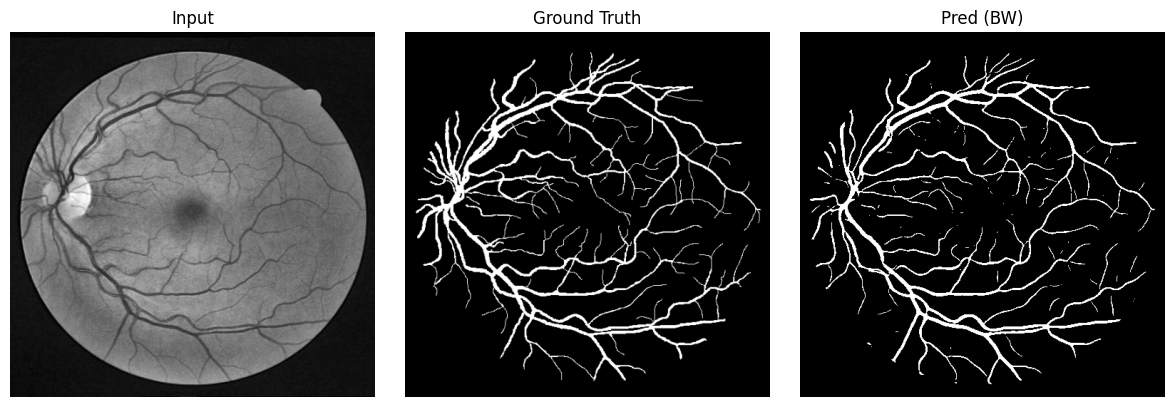

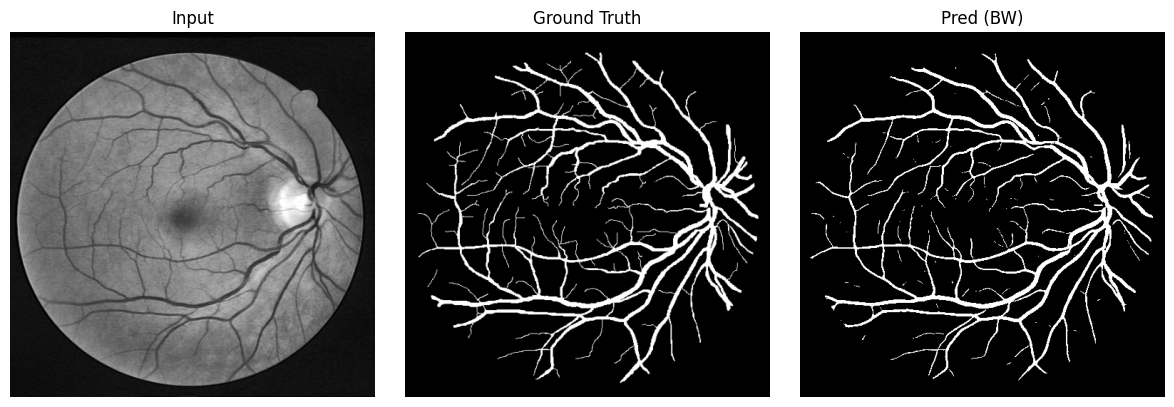

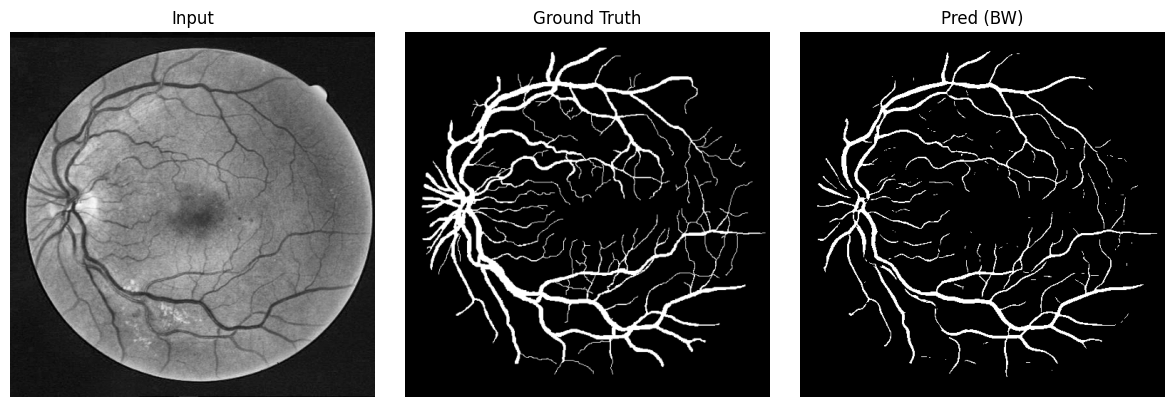

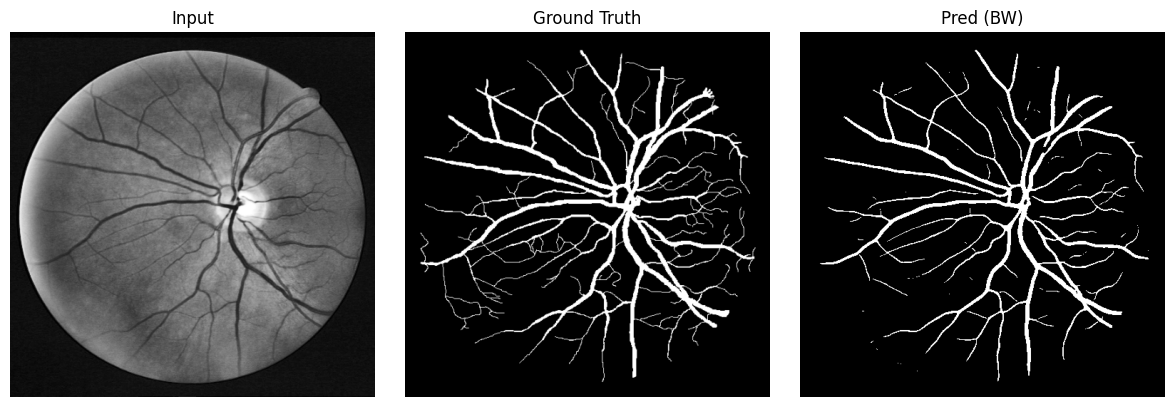

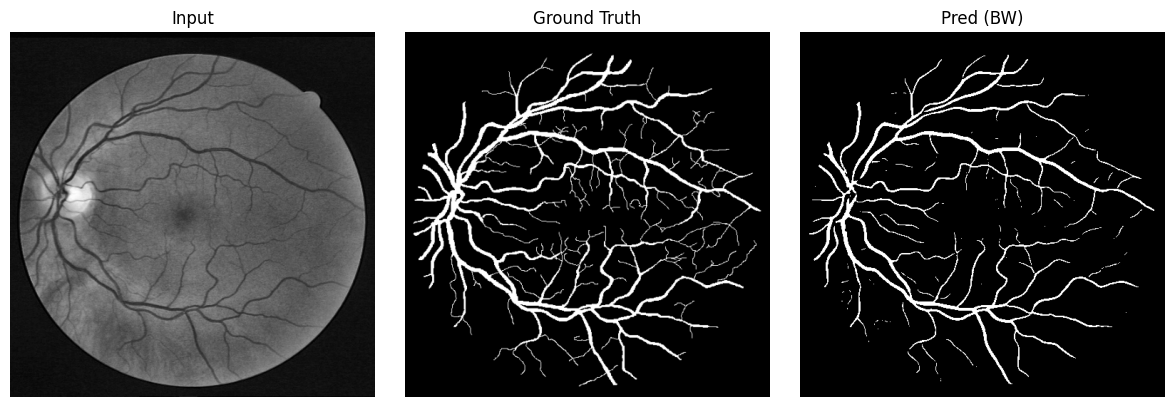

In [9]:
# -----------------------------------
# 6. Visualize Predictions
# -----------------------------------
import matplotlib.pyplot as plt

def display_results(i):
    fig, axs = plt.subplots(1, 3, figsize=(12,4))
    # Input
    axs[0].imshow(X_test[i].squeeze(), cmap='gray')
    axs[0].set_title("Input")
    axs[0].axis('off')
    # Ground truth
    axs[1].imshow(y_test[i].squeeze(), cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[1].axis('off')
    # Prediction (binary)
    axs[2].imshow(preds_bin[i].squeeze(), cmap='gray')
    axs[2].set_title("Pred (BW)")
    axs[2].axis('off')
    plt.tight_layout()
    plt.show()

# show first 5 results
for i in range(5):
    display_results(i)


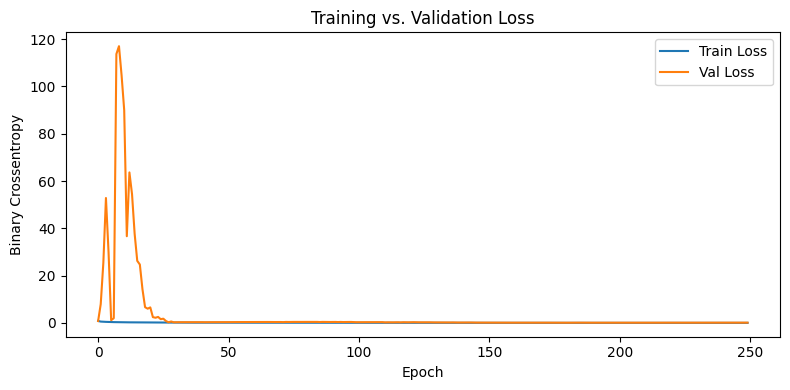

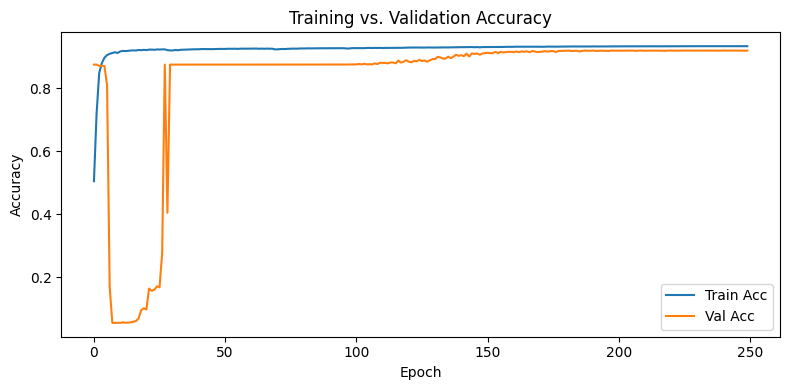

In [10]:
# -----------------------------------
# 7. Plot Training & Validation Metrics
# -----------------------------------
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],     label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()
plt.tight_layout()
plt.show()

# Accuracy
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'],      label='Train Acc')
plt.plot(history.history['val_accuracy'],  label='Val Acc')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()
